In [50]:
# 新增jupyter的话，需要拷贝下面的初始化设置
import sys
import os

if '/Users/zhang/PycharmProjects/strategy_engine_v2' not in sys.path:
    sys.path.append("/Users/zhang/PycharmProjects/strategy_engine_v2")
os.environ['config.dir'] = "/Users/zhang/PycharmProjects/strategy_engine_v2/interface"
os.environ['config.log'] = "/Users/zhang/PycharmProjects/strategy_engine_v2/interface/log_jupyter.yaml"
# 如果没有日志目录的话，则创建
if not os.path.exists("log"):
    os.makedirs("log")

In [52]:
# 下载数据
from se import BeanContainer
from se.domain2.time_series.time_series import HistoryDataQueryCommand, TimeSeriesRepo, TimeSeries
import pandas as pd
start = pd.Timestamp("2019-06-10", tz='Asia/Shanghai')
end = pd.Timestamp("2020-12-01", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['GSX_STK_USD_SMART'])
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)
ts: TimeSeries = ts_repo.find_one("ibMinBar")
ts.download_data(command)
print(ts.data_record)


(MainThread) 2021-01-27 19:51:19 INFO     time_series.py:325 下载完成， 共下载了0个数据
{'BABA_STK_USD_SMART': <se.domain2.time_series.time_series.DataRecord object at 0x7ff493eef040>, 'CCL_STK_USD_SMART': <se.domain2.time_series.time_series.DataRecord object at 0x7ff4940a3f40>, 'GSX_STK_USD_SMART': <se.domain2.time_series.time_series.DataRecord object at 0x7ff4940c00d0>, 'SPCE_STK_USD_SMART': <se.domain2.time_series.time_series.DataRecord object at 0x7ff493ee8cd0>, 'TSLA_STK_USD_SMART': <se.domain2.time_series.time_series.DataRecord object at 0x7ff496c1feb0>}


In [53]:
# 计算日内回报、日间回报、以及总回报序列
start = pd.Timestamp("2019-06-10", tz='Asia/Shanghai')
end = pd.Timestamp("2020-12-01", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['GSX_STK_USD_SMART'])
df = ts.history_data(command, from_local=True)
df = df.droplevel(level=1)
# 注意origin的tz必须跟原始的DataFrame的DatetimeIndex的timezone相同
df = df.resample('1D', origin=pd.Timestamp("2020-01-01 21:00:00", tz='Asia/Shanghai'))\
    .agg({'open': 'first', 'close': 'last'}).dropna()
close_to_open_rets = (df['open'].shift(-1) - df['close']) / df['close']
close_to_close_rets = (df['close'].shift(-1) - df['close']) / df['close']
open_to_close_rets = (df['close'] - df['open']) / df['open']

,oc,co,cc
visible_time,,,
2020-11-23 21:00:00+08:00,0.071281,0.252353,0.355213
2020-11-24 21:00:00+08:00,0.085708,0.233296,0.344225
2020-11-25 21:00:00+08:00,0.093544,0.238226,0.338174
2020-11-27 21:00:00+08:00,0.084288,0.204767,0.283232
2020-11-30 21:00:00+08:00,0.068646,NaN,NaN


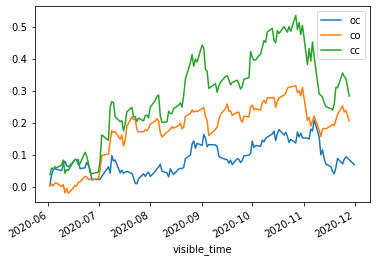

In [54]:
# 计算累计收益曲线
dd = pd.DataFrame({"oc":(1+open_to_close_rets).cumprod() - 1, "co":(1+close_to_open_rets).cumprod() - 1,
                   "cc": (1+close_to_close_rets).cumprod() - 1})
dd.plot()
dd.tail(5)

<AxesSubplot:xlabel='visible_time'>

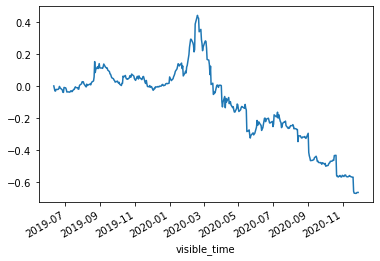

In [8]:
dd['co'].plot()

In [19]:
# close_to_open 与下一个 open_to_close 之间的相关性
df = pd.DataFrame({"co": close_to_open_rets, 'oc': open_to_close_rets.shift(-1)}).dropna()
print(df.corr(method='spearman'))
df.describe()


          co        oc
co  1.000000 -0.137045
oc -0.137045  1.000000


,co,oc
count,373.000000,373.000000
mean,-0.002419,0.009236
std,0.030919,0.048809
min,-0.219199,-0.165327
25%,-0.010280,-0.017143
50%,0.000000,0.008471
75%,0.009972,0.034997
max,0.130145,0.209021


In [49]:
profit_rets = open_to_close_rets[open_to_close_rets>0]
loss_rets = open_to_close_rets[open_to_close_rets<0]
print("open_to_close, profit rate:{}, profit mean:{}, loss mean:{}".format(
    len(profit_rets)/float(len(open_to_close_rets)),
    profit_rets.mean(),
    loss_rets.mean()
))

profit_rets = close_to_close_rets[close_to_close_rets>0]
loss_rets = close_to_close_rets[close_to_close_rets<0]
print("close_to_close, profit rate:{}, profit mean:{}, loss mean:{}".format(
    len(profit_rets)/float(len(close_to_close_rets)),
    profit_rets.mean(),
    loss_rets.mean()
))



open_to_close, profit rate:0.603448275862069, profit mean:0.0417929362874068, loss mean:-0.03626457229268872
close_to_close, profit rate:0.5344827586206896, profit mean:0.04689078433108469, loss mean:-0.04033103071371096


In [12]:
# 统计不同的close_to_open的水平下， open_to_close的统计量，包括平均回报、胜率、方差、平均盈利、平均亏损
df = pd.DataFrame({"co": close_to_open_rets, 'oc': open_to_close_rets.shift(-1)}).dropna()
bins = [-0.21, -0.1, -0.05, -0.025, 0, 0.025, 0.05, 0.1, 0.15]
df['co_bins'] = pd.cut(df['co'], bins)
oc_grouped = df.groupby('co_bins').oc
oc_result = pd.DataFrame({"oc_mean": oc_grouped.mean(),
                                  "oc_count": oc_grouped.count(),
                                  "oc_std": oc_grouped.std()})
oc_result

,oc_mean,oc_count,oc_std
co_bins,,,
"(-0.21, -0.1]",0.075947,5,0.060507
"(-0.1, -0.05]",0.042219,9,0.066531
"(-0.05, -0.025]",0.004146,25,0.044942
"(-0.025, 0.0]",0.013803,154,0.045252
"(0.0, 0.025]",0.006730,152,0.043547
"(0.025, 0.05]",-0.007335,17,0.064729
"(0.05, 0.1]",-0.033340,9,0.076473
"(0.1, 0.15]",-0.028982,1,NaN


<AxesSubplot:xlabel='visible_time'>

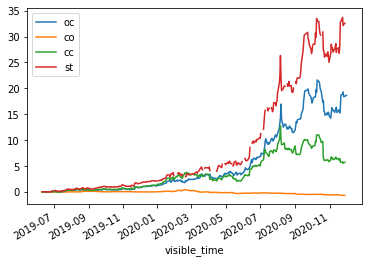

In [13]:
# 当close_to_open小于0.025的时候，在当天开盘的时候买入，持有到收盘卖出
dd = pd.DataFrame({"oc":(1+open_to_close_rets).cumprod() - 1, "co":(1+close_to_open_rets).cumprod() - 1,
                   "cc": (1+close_to_close_rets).cumprod() - 1})
df = pd.DataFrame({"co": close_to_open_rets, 'oc': open_to_close_rets.shift(-1)}).dropna()
dd['st'] = (1+df[df['co']<0.025]['oc']).cumprod()-1
dd.plot()


<AxesSubplot:xlabel='visible_time'>

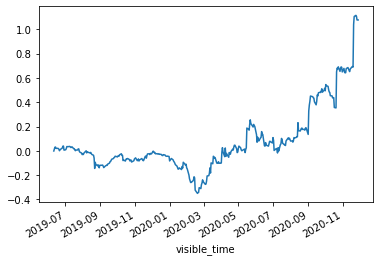

In [15]:
# 收盘做空，第二天平仓的累计收益曲线
((1-close_to_open_rets).cumprod()-1).plot()

In [20]:
# 下面考虑open_to_close与下一个close_to_open之间的相关性
dd = pd.DataFrame({"oc":open_to_close_rets, "co":close_to_open_rets})

print(dd.corr(method='spearman'))
dd.describe()

          oc        co
oc  1.000000  0.078072
co  0.078072  1.000000


,oc,co
count,374.000000,373.000000
mean,0.009165,-0.002419
std,0.048763,0.030919
min,-0.165327,-0.219199
25%,-0.017390,-0.010280
50%,0.008190,0.000000
75%,0.034915,0.009972
max,0.209021,0.130145


In [21]:
# 从上面可以看出，日内涨幅跟下一个日间涨幅存在非常微弱的相关性， 0.078

# 下面统计不同的open_to_close水平下，close_to_open的统计量，均值、数量、标准差
df = pd.DataFrame({"oc":open_to_close_rets, "co":close_to_open_rets})

bins = [-0.16, -0.1, -0.05, -0.025, 0, 0.025, 0.05, 0.1, 0.20]
df['oc_bins'] = pd.cut(df['oc'], bins)
co_grouped = df.groupby('oc_bins').co
co_result = pd.DataFrame({"co_mean": co_grouped.mean(),
                                  "co_count": co_grouped.count(),
                                  "co_std": co_grouped.std()})
co_result

,co_mean,co_count,co_std
oc_bins,,,
"(-0.16, -0.1]",0.000822,7,0.026992
"(-0.1, -0.05]",-0.003844,20,0.039983
"(-0.05, -0.025]",-0.001432,48,0.020650
"(-0.025, 0.0]",-0.000793,80,0.023032
"(0.0, 0.025]",-0.004566,97,0.030256
"(0.025, 0.05]",-0.005189,58,0.038762
"(0.05, 0.1]",0.002437,47,0.036788
"(0.1, 0.2]",-0.007403,13,0.028617


<AxesSubplot:xlabel='visible_time'>

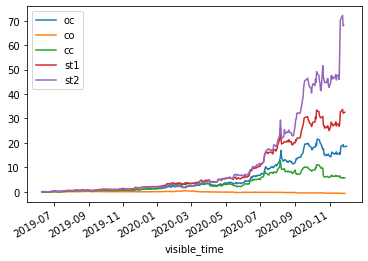

In [30]:
# 如果在之前的基础上，附加上在收盘的时候卖空的操作，并且在第二天开盘的时候买入
next_open_to_close = open_to_close_rets.shift(-1)
next_close_to_open = close_to_open_rets.shift(-1)
choosed_oc = next_open_to_close.copy()
choosed_oc[close_to_open_rets>0.025] = 0
choosed_oc_and_short_co = ((1+choosed_oc) * (1-next_close_to_open)) - 1


cum_df = pd.DataFrame({"oc":(1+open_to_close_rets).cumprod() - 1, "co":(1+close_to_open_rets).cumprod() - 1,
                   "cc": (1+close_to_close_rets).cumprod() - 1,
                       'st1': (1 + choosed_oc).cumprod() - 1,
                       'st2': (1 + choosed_oc_and_short_co).cumprod() - 1
                       })
cum_df.plot()

In [49]:
df = pd.DataFrame({"oc":open_to_close_rets, "co":close_to_open_rets, 'nco':next_close_to_open,
                   "choosed_oc": choosed_oc, "choosed_oc_and_short_co": choosed_oc_and_short_co})


,oc,co,nco,choosed_oc,choosed_oc_and_short_co
visible_time,,,,,
2020-11-17 21:00:00+08:00,0.006545,-0.001979,0.002500,-0.036686,-0.039093
2020-11-18 21:00:00+08:00,-0.036686,0.002500,-0.206727,0.046495,0.262834
2020-11-19 21:00:00+08:00,0.046495,-0.206727,-0.032744,0.160071,0.198057
2020-11-20 21:00:00+08:00,0.160071,-0.032744,-0.004538,0.006141,0.010707
2020-11-23 21:00:00+08:00,0.006141,-0.004538,0.003535,0.022952,0.019337
2020-11-24 21:00:00+08:00,0.022952,0.003535,0.014430,-0.044870,-0.058652
2020-11-25 21:00:00+08:00,-0.044870,0.014430,0.000000,0.005532,0.005532
2020-11-27 21:00:00+08:00,0.005532,0.000000,NaN,0.007230,NaN
2020-11-30 21:00:00+08:00,0.007230,NaN,NaN,NaN,NaN


<AxesSubplot:>

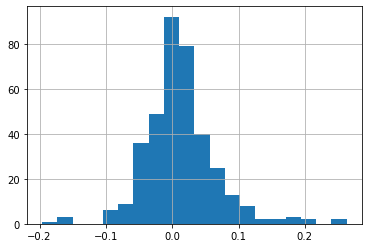

In [46]:
choosed_oc_and_short_co.hist(bins=20)

<AxesSubplot:>

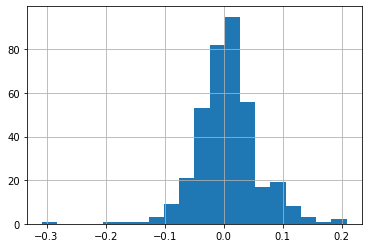

In [47]:
close_to_close_rets.hist(bins=20)

In [48]:
choosed_oc_and_short_co[choosed_oc_and_short_co>0.2]

visible_time
2020-10-19 21:00:00+08:00    0.241393
2020-11-18 21:00:00+08:00    0.262834
dtype: float64